# Explore here

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pickle import dump

import shap

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_recall_curve,roc_curve,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

from xgboost import XGBClassifier, plot_importance

In [104]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")

df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [106]:
X = df.drop(["Outcome"], axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [107]:
parametros = {
    "n_estimators" : [100, 200, 300],
    "learning_rate" : [0.01, 0.1, 0.2],
    "subsample" : [0.7, 0.8, 0.9, 1],
    "max_depth" : [3, 4, 5],
    "gamma" : [0, 1, 3],
    "min_child_weight" : [1, 3, 5],
    "colsample_bytree" : [0.6, 0.8, 1.0],
    "colsample_bylevel" : [0.6, 0.8, 1.0]
}

In [108]:
modelo = XGBClassifier(eval_metric='auc', random_state = 42)
busqueda = RandomizedSearchCV(modelo, parametros, n_iter=10, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
busqueda.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrai...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.6, 0.8, 1.0],
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 3],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.8, 0.9, 1]},
                   scoring='accuracy', verbose=1)

In [109]:
best_clf = busqueda.best_estimator_
y_proba = best_clf.predict_proba(X_test)[:, 1]

In [110]:
# --- 5. Evaluación AUC global ---
print(f"\n✅ AUC (usando y_proba): {roc_auc_score(y_test, y_proba):.3f}")


✅ AUC (usando y_proba): 0.823


In [111]:
df_eval = pd.DataFrame({'true': y_test, 'proba': y_proba})
thresholds = np.quantile(df_eval['proba'], np.linspace(0.1, 0.9, 9))
scores = []

for t in thresholds:
    pred = (df_eval['proba'] >= t).astype(int)
    f1 = f1_score(df_eval['true'], pred)
    scores.append((t, f1))

print("\n📊 --- F1 Score por punto de corte (cuantiles) ---")
for t, f1 in scores:
    print(f"Threshold: {t:.2f} | F1 Score: {f1:.3f}")


📊 --- F1 Score por punto de corte (cuantiles) ---
Threshold: 0.05 | F1 Score: 0.570
Threshold: 0.08 | F1 Score: 0.607
Threshold: 0.14 | F1 Score: 0.626
Threshold: 0.20 | F1 Score: 0.653
Threshold: 0.32 | F1 Score: 0.667
Threshold: 0.45 | F1 Score: 0.650
Threshold: 0.62 | F1 Score: 0.693
Threshold: 0.73 | F1 Score: 0.628
Threshold: 0.78 | F1 Score: 0.394


In [112]:
best_threshold = max(scores, key=lambda x: x[1])[0]
y_pred = (y_proba >= best_threshold).astype(int)
print(f"\n⭐ Mejor punto de corte (F1): {best_threshold:.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"AUC (de nuevo con proba): {roc_auc_score(y_test, y_proba):.3f}")


⭐ Mejor punto de corte (F1): 0.62
F1 Score: 0.693
AUC (de nuevo con proba): 0.823


In [113]:
y_pred=(y_proba>best_threshold).astype(int)

In [114]:
accuracy_score(y_test, y_pred)

0.7987012987012987

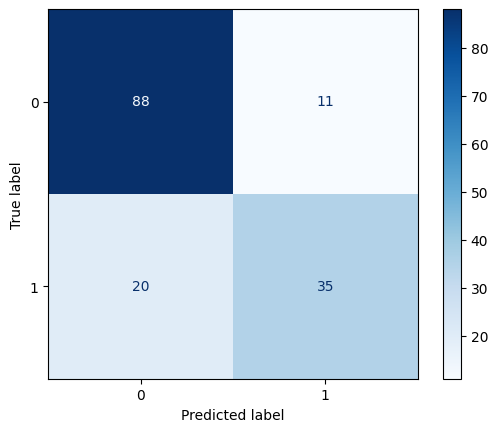

In [115]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.show()

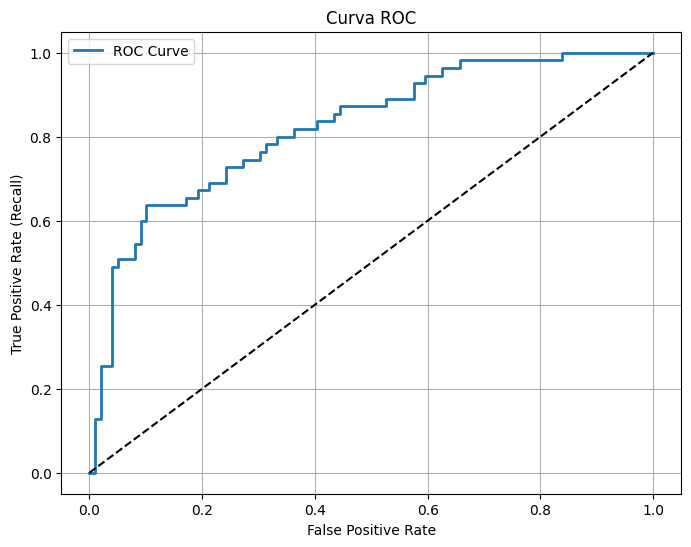

In [126]:
# --- 8. Curva ROC ---
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

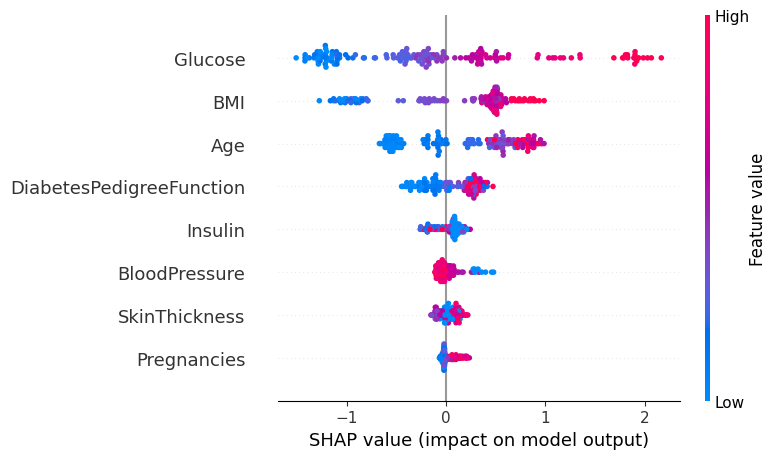

In [117]:
# --- 10. Interpretación SHAP ---
explainer = shap.Explainer(best_clf, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

<Figure size 1000x600 with 0 Axes>

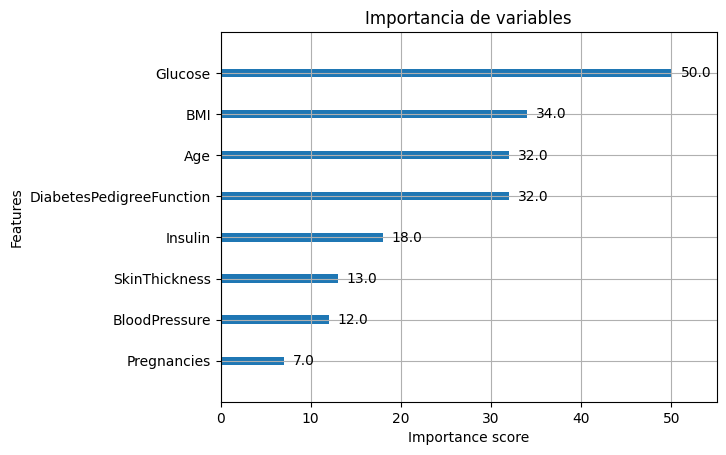

In [118]:
# --- 11. Importancia de variables ---
plt.figure(figsize=(10, 6))
plot_importance(best_clf)
plt.title("Importancia de variables")
plt.show()

In [120]:
dump(modelo, open("../models/boosting_classifier_100_0.1_0.9_5_3_3_0.6_1.0_42.sav", "wb"))

## La Precisión (Accuracy) del modelo es  = 0.7987